TO RUN THE CODE:

In [1]:
# packages
import numpy as np
from scipy.optimize import fsolve
import planet as mp
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap, ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable

# local modules
import disk as ds

R_sun                   = 6.957e+8             # m
M_sun                   = 1.989e+30            # kg
M_e                     = ds.M_e
auSI                    = ds.auSI
yr                      = ds.yr
M_j                     = 1.898e27            # kg


---------------------------
---------------------------
-- Disk structure module --
---------------------------
---------------------------
   All units are SI unless stated otherwise.

-- Setting up a disk subclass: pure viscous  (Chambers 2009)
-- Setting up a disk subclass: viscous and irradiated (Chambers 2009)


Surface density and midplane temperature profiles for disk

/Users/annathomas/Library/CloudStorage/OneDrive-UniversityCollegeLondon/phd/code/sponch-lite/sponchpop-lite/disk.py:476: RuntimeWarning: divide by zero encountered in reciprocal
  (Sigma[mask_mixed]/self.Sigma_0)**(-1) * \


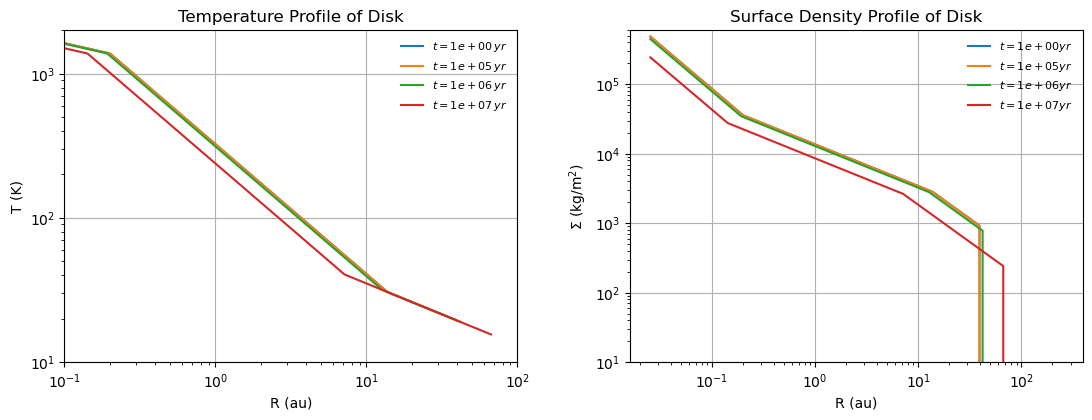

In [3]:
# List of disk models to be used
disk_models = [ds.disk_viscirr, ds.disk_visc]
# ds.disk_viscirr is disk model with heating driven by viscous transport and stellar irradiation
# ds.disk_visc is disk model with heating driven by viscous transport only

disk_args= {'disk_subclass': ds.disk_viscirr, 
            'M_0':0.05*M_sun,                    # kg, initial mass of disk
            'alpha':1e-4,                        # dimensionless, viscosity parameter
            's_0': 33*auSI,                      # m, initial location of disk inner edge
            'T_e': 1380.0,                       # K, initial temperature of disk midplane at inner edge 
            'M_star': 1.0*M_sun,                 # kg, mass of central star
            'T_star': 4200.0,                    # K, effective temperature of central star
            'R_star': 1.0*R_sun,                 # m, radius of central star
            'kappa_0': 0.3,                      # m^2/kg, opacity 
            'mu': 2.4,                           # dimensionless, mean molecular weight of gas in disk 
            'dtgr': 0.015,                       # dimensionless, dust-to-gas ratio in disk
            'plnr': 0.0,                         # dimensionless, fraction of planetesimals of solids
            'pebr': 0.995,                       # dimensionless, fraction of pebbles of solids
            'dustr': 0.005,                      # dimensionless, fraction of dust in solids
            'vfrag': 2.5,                         # m/s, fragmentation velocity
            'rhos': 1250}                        # kg/m^3, density of solids in disk

# Set up the disk model, chosing the disk subclass and passing the arguments
disk_model  = ds.DiskPlanetforming(**disk_args)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.tight_layout(pad=5.0)

rad_grid                       = np.array(disk_model.rstruct())
grid_sizes                     = np.diff(rad_grid) 
r_grid_centres                 = 0.5*(rad_grid[1:] + rad_grid[:-1]) 

# Plotting the temperature and surface density profiles of the disk
times = [1*yr, 1e5*yr, 1e6*yr, 1e7*yr]

axs[0].grid()
for time in [float(1*yr), float(1e5*yr), float(1e6*yr), float(1e7*yr)]:
    temps = disk_model.get_T(r_grid_centres, time, disk_model.validate(radius=r_grid_centres[1], time=time))
    axs[0].plot(r_grid_centres/auSI, temps, linewidth=1.5, label=r'$t=%.e\, yr$' % (time/yr))
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('R (au)')
axs[0].set_ylabel('T (K)')
axs[0].set_xlim([0.1, 100])
axs[0].set_ylim([10, 2000])
axs[0].set_title('Temperature Profile of Disk')
axs[0].legend(loc='upper right', frameon=False, fontsize=8)
axs[1].grid()
for time in [float(1*yr), float(1e5*yr), float(1e6*yr), float(1e7*yr)]:
    sigs = disk_model.get_Sigma(r_grid_centres, time, disk_model.validate(radius=r_grid_centres[1], time=time))
    axs[1].plot(r_grid_centres/auSI, sigs, linewidth=1.5, label=r'$t=%.e yr$' % (time/yr))
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_ylim([1e1,6e5])
axs[1].set_xlabel('R (au)')
axs[1].set_ylabel(r'$\Sigma$ (kg/m$^2$)')
axs[1].set_title('Surface Density Profile of Disk')
axs[1].legend(loc='upper right', frameon=False, fontsize=8)

In [8]:
timestep_yrs     = 150          # yrs, time step of simulation
birth_time_yrs   = 1e4           # yrs, time of birth of planet

planet_args = {'a_0': 3 * ds.auSI,                  # m , birth semi-major axis of planet
               't_0': birth_time_yrs,               # yrs, birth time of planet
               'm_0' : 1e-5 * ds.M_e ,              # kg, birth mass of planet
               'B' : 4,                             # dimensionless, width of feeding zone of planetesimals in hill spheres  
               'p_ratio' : 0.5,                     # dimensionless, fraction of planetesimals adding to the mass of the envelope/core after pebble isolation mass is reached
               'dt_yrs': timestep_yrs,              # yrs, time step of simulation
               'PDM' : False,                       # boolean, whether to include planetesimal driven migration
               'migration' : True,                  # boolean, whether to include disk driven migration
               'peb_acc' : True,                    # boolean, whether to include pebble accretion
               'plan_acc' : False,                  # boolean, whether to include planetesimal accretion
               'gas_acc' : True,                    # boolean, whether to include gas accretion
               'grain_growth' : False,              # boolean, whether to include grain growth
               'pebble_drift' : True,              # boolean, whether to include pebble drift
               'disk' : disk_model}                 # disk model to be used (chosen in disk_args)

disk_model  = ds.DiskPlanetforming(**disk_args)

planet_new = mp.planet_disk_evo(**{**planet_args, 'disk': disk_model})
planet_new.single_planet_case()
array, time = planet_new.get_vals()
print(f'Birth location = {planet_new.a_0/auSI:.2f} AU \nBirth mass = {planet_new.m_0/M_e:.5f} M_e')
print(f'Final mass = {array[-1,1]/M_e:.2f} M_e \nFinal location = {array[-1,2]/auSI:.2f} AU')

indp, indc, indm, final_pebble_surface_density, final_planetesimal_grid, pebble_sigma_evo  = planet_new.get_other()

/Users/danielaliev/University /Summer Astro Project/sponchpop-lite/disk.py:729: RuntimeWarning: divide by zero encountered in true_divide
  St = (pebble_size * rho_solid/sigma) * (np.pi/2)
Progress:   0%|          | 0/20067 [00:00<?, ?step/s]/Users/danielaliev/University /Summer Astro Project/sponchpop-lite/disk.py:1025: RuntimeWarning: invalid value encountered in multiply
  v_r = (2 * eta * vkep * St) / (1 + St**2)
Progress: 100%|██████████| 20067/20067 [00:42<00:00, 475.07step/s]

Birth location = 3.00 AU 
Birth mass = 0.00001 M_e
Final mass = 32.63 M_e 
Final location = 0.03 AU


(10000.0, 4000000.0)

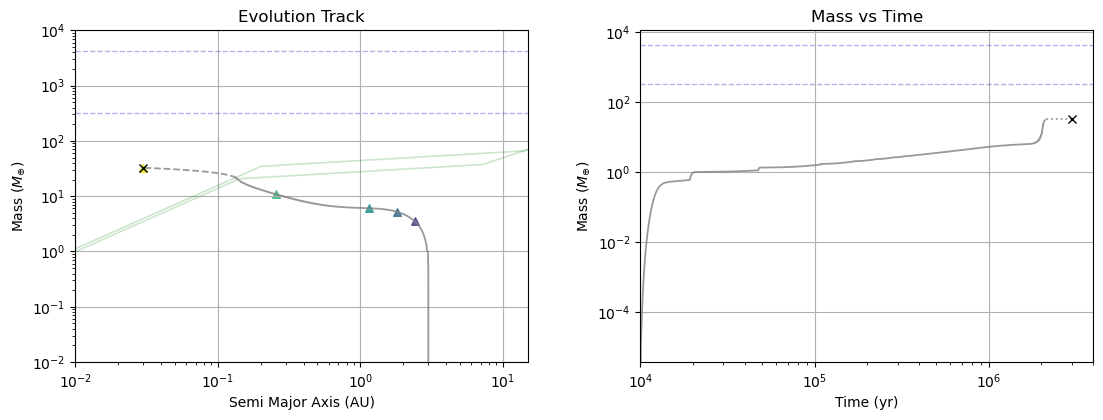

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.tight_layout(pad=5.0)

# Evolution Track 
axs[0].grid()
axs[0].set_title('Evolution Track')
axs[0].set_xlabel('Semi Major Axis (AU)')
axs[0].set_ylabel('Mass $(M_{\oplus})$')
axs[0].axhline((13 * M_j) / M_e, alpha=0.3, linestyle='dashed', linewidth=1, color='mediumblue')
axs[0].axhline((1 * M_j) / M_e, alpha=0.3, linestyle='dashed', linewidth=1, color='mediumblue')
axs[1].axhline((13 * M_j) / M_e, alpha=0.3, linestyle='dashed', linewidth=1, color='mediumblue')
axs[1].axhline((1 * M_j) / M_e, alpha=0.3, linestyle='dashed', linewidth=1, color='mediumblue')

radii = np.arange(0.001, 100.1, 2e-3) * auSI

# Calculate temperatures at t=0 and t=1e7*yr for all radii at once
temp_low = disk_model.get_T(time=0.0, radius=radii, status=1)
temp_high = disk_model.get_T(time=1e7*yr, radius=radii, status=1)

# Calculate pebble isolation mass for all radii at once
peb_iso_lower = disk_model.get_iso_peb(radius=radii, temperature=temp_low, status=1)
peb_iso_upper = disk_model.get_iso_peb(radius=radii, temperature=temp_high, status=1)

axs[0].loglog(radii/auSI, peb_iso_lower/M_e, alpha=0.2, color='green', linewidth=1.2)
axs[0].loglog(radii/auSI, peb_iso_upper/M_e, alpha=0.2, color='green', linewidth=1.2)

if indc is None:
    axs[0].loglog((array[:, 2]) / auSI, (array[:, 1]) / M_e, alpha=0.8, color='grey', linewidth=1.3, label='Vectorised')
    axs[1].loglog((time)/yr, array[:,1]/M_e, alpha=0.8, color='grey', linewidth=1.3)
    axs[1].plot((time[-1] )/yr, array[:,1][-1]/M_e, 'kx', markersize = 6)
    axs[0].plot(array[-1, 2] / auSI, (array[-1, 1]) / M_e, 'kx', markersize = 6)
else:
    axs[0].loglog((array[:, 2][0:indp - 1]) / auSI, (array[:, 1][0:indp - 1]) / M_e, alpha=0.8, color='grey', linewidth=1.3, label='Vectorised')
    axs[0].loglog((array[:, 2][indp:indc]) / auSI, (array[:, 1][indp:indc]) / M_e, alpha=0.8, color='grey', linewidth=1.3, linestyle='dashed')
    axs[0].loglog((array[:, 2][indc:-1]) / auSI, (array[:, 1][indc:-1]) / M_e, alpha=0.8, color='grey', linewidth=1.3, linestyle='dotted')
    axs[1].loglog((time )[0:indp - 1]/yr, array[:,1][0:indp - 1]/M_e, alpha=0.8, color='grey', linewidth=1.3)
    axs[1].loglog((time )[indp:indc]/yr, array[:,1][indp:indc]/M_e, alpha=0.8, color='grey', linewidth=1.3, linestyle='dashed')
    axs[1].loglog((time )[indc:-1]/yr, array[:,1][indc:-1]/M_e, alpha=0.8, color='grey', linewidth=1.3, linestyle='dotted')
    axs[1].plot((time[-1] )/yr, array[:,1][-1]/M_e, 'kx', markersize = 6)
    axs[0].plot(array[-1, 2] / auSI, (array[-1, 1]) / M_e, 'kx', markersize = 6)

cmap = get_cmap('viridis', len(time))
norm = mcolors.Normalize(vmin=0, vmax=np.max(time / yr - time[0] / yr))
for t in np.arange(0, np.max(time / yr - time[0] / yr), 0.5e6):  # placing markers every however many years
    idx = np.searchsorted(time / yr - time[0] / yr, t)
    if idx < len(array[:, 2]):
        a = array[:, 2][idx] / auSI
        m = array[:, 1][idx] / M_e
        axs[0].scatter(a, m, color=cmap(norm(t)), marker='^', s=30, alpha=0.8)

# Mass vs Time
axs[1].grid()
axs[1].set_title('Mass vs Time')
axs[1].set_xlabel('Time (yr)')
axs[1].set_ylabel('Mass $(M_{\oplus})$')
axs[0].set_xlim(0.01, 15)
axs[0].set_ylim(0.01, 10000)
axs[1].set_xlim(1e4, 4e6)

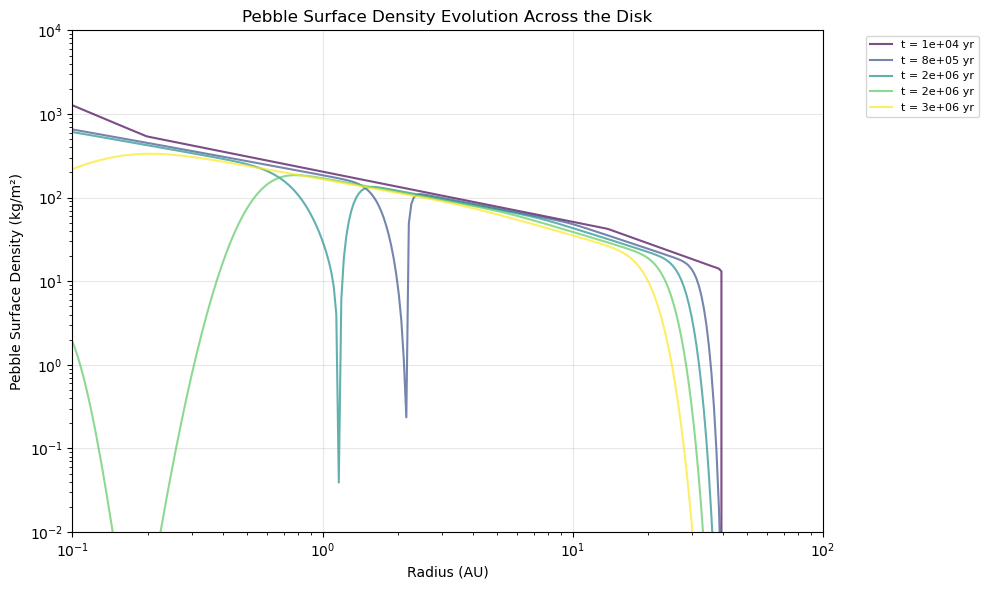

Plotted pebble surface density for 5 timesteps
Total simulation timesteps: 20067
Timestep interval: 150 years


In [15]:
# Plot pebble surface density evolution across the disk every 1000 timesteps
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Get the radial grid
rad_grid = np.array(disk_model.rstruct())
grid_sizes = np.diff(rad_grid) 
r_grid_centres = 0.5*(rad_grid[1:] + rad_grid[:-1])

# Plot every 1000 timesteps
step_interval = 5000
total_timesteps = len(pebble_sigma_evo)

# Create a colormap for different timesteps
cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, len(range(0, total_timesteps, step_interval))))

for i, timestep_idx in enumerate(range(0, total_timesteps, step_interval)):
    if timestep_idx < len(pebble_sigma_evo):
        # Convert timestep to actual time in years
        actual_time = (birth_time_yrs + timestep_idx * timestep_yrs)
        
        # Plot the pebble surface density at this timestep
        ax.loglog(r_grid_centres/auSI, pebble_sigma_evo[timestep_idx], 
                 color=colors[i], linewidth=1.5, alpha=0.7,
                 label=f't = {actual_time:.0e} yr')

ax.set_xlabel('Radius (AU)')
ax.set_ylabel('Pebble Surface Density (kg/m²)')
ax.set_title('Pebble Surface Density Evolution Across the Disk')
ax.grid(True, alpha=0.3)
ax.set_xlim([0.1, 100])
ax.set_ylim([1e-2, 1e4])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

print(f"Plotted pebble surface density for {len(range(0, total_timesteps, step_interval))} timesteps")
print(f"Total simulation timesteps: {total_timesteps}")
print(f"Timestep interval: {timestep_yrs} years")